# Decision Trees and Random Forests

In [1]:
#import data handling and graphing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

#import Scikit-learn libraries
from sklearn import preprocessing
from sklearn import tree #to fit a decision tree classifier
from sklearn.ensemble import RandomForestClassifier #this fits several 'randomly' grown trees
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
%matplotlib inline

## Exploration

In [2]:
df = pd.read_csv('data.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
df.shape

(891, 12)

In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
#identify missing values (note for future: this should be done early during exploration)
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Pre-processing

In [7]:
#drop variables without predictive power
df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [8]:
#identify categorical variables to convert to numeric: Pclass, Sex, Embarked
df.dtypes
#change Pclass to object (str) to generate dummy

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [9]:
df['Pclass'] = df['Pclass'].astype(str)
df.dtypes

Survived      int64
Pclass       object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [10]:
#use dummies to convert categorical variables to numeric
df = pd.get_dummies(df, drop_first=True)
df.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0,1,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,1,0,1


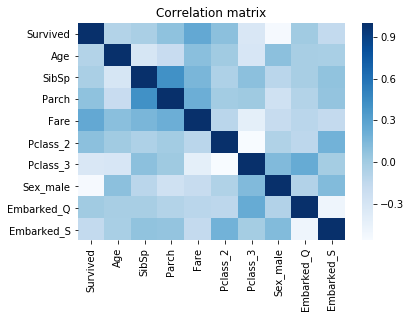

In [11]:
#check correlation (cannot use perfectly correlated variables)
sns.heatmap(df.corr(), cmap='Blues')
plt.title('Correlation matrix')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [8, 6]
plt.show() #no problem

In [12]:
#drop missing values (1/5th Age observations + 2 Cabin observations)
#do this at the end of pre-processing
df = df.dropna()
df = df.reset_index(drop=True) #reset index
df.shape

(714, 10)

In [13]:
df.isnull().sum()

Survived      0
Age           0
SibSp         0
Parch         0
Fare          0
Pclass_2      0
Pclass_3      0
Sex_male      0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [14]:
#split data intro training and test samples
#first, create X (features) and Y (outcome) dataframes
X = df.drop(['Survived'], axis=1)
X.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [15]:
Y = df['Survived']
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
#random_state value does not matter, only matters setting it to something and being consistent
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(535, 9) (535,)
(179, 9) (179,)


## Fit a decision tree

In [17]:
#create an empty decision tree with max depth = 3 (small tree, easy to start with and to graph)
#i.e. tree depth = length of the longest path from a root to a leaf
dtree = tree.DecisionTreeClassifier(max_depth=3)
#visualise parameters (mostly defaults)
dtree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [18]:
#fit the decision tree to the training data
dtree = dtree.fit(X_train, Y_train)
#predict the outcome Y ('Survived') using X values in test data
Y_pred = dtree.predict(X_test) #store these predictions in Y_pred

## Decision tree: model performance

In [19]:
#look at tree performance (TP/TN/FP/FN ratios)
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[89 14]
 [22 54]]


In [20]:
accuracy_score(Y_test, Y_pred)

0.7988826815642458

In [21]:
#check accuracy score manually: accu = (TP+TN)/total n
(54+89)/(89+14+22+54) #correct

0.7988826815642458

The predictions of this decision tree are approx. 80% accurate.

## Learnings

Steps to fit a decision tree model:
    
    1. Import sklearn relevant packages
    2. Create an empty decision tree, specify parameters (e.g. max depth)
    3. Fit the tree to the training data
    4. Predict Y in the test data using X test, store these predictions
    5. Look at model accuracy (confusion matrix and/or accuracy), can cross-check manually

## Visualising the decision tree - suggestions welcome

I tried to visualise the fitted tree using graphviz and pydotplus but I struggled with installing the packages. This might be due to the fact that I was using an externally managed (not personal) computer.

In [22]:
from sklearn.tree import export_graphviz
export_graphviz(dtree, out_file='tree.dot', 
                feature_names = X_train.columns.values.tolist(),
                class_names = ['Died','Survived'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [23]:
import sys
!{sys.executable} -m pip install pydotplus

'C:\Program' is not recognized as an internal or external command,
operable program or batch file.


In [24]:
!conda install --yes --prefix {sys.prefix} pydotplus


EnvironmentLocationNotFound: Not a conda environment: C:\Program



## Under- vs. overfitting with decision trees

I want to explore the performance of decision trees with different depths because a small tree will likely under-fit the data while a very deep tree might overfit it. I want to find the optimal tree depth to predict survivors on the Titanic using this dataset. To test this, I fit trees of depths ranging from 2 to 11, and I plot the performance in the training and in the test data. Then, I compare the model performance of each tree. I repeat the steps I identified above to fit the decision tree.

In [25]:
#step 2: create empty decision tree (dtree2), specify max depth = 11
depth = list(range(1,12))

#step 5: retrospectively, create empty lists to store model performance results
#otherwise, the loop overwrites previous result
train_perf = []
test_perf = []

for i in range(1,12):
    dtree2 = tree.DecisionTreeClassifier(max_depth=i)
    
    #step 3: fit trees of different depths to training data
    dtree2.fit(X_train, Y_train)
    
    #step 4: predict Y outcome in training + test data using X train + X test
    #store prediction as Y_pred (train and test repectively)
    Y_train_pred = dtree2.predict(X_train)
    Y_test_pred = dtree2.predict(X_test)
    
    #step 5: compare model performance between training/test data + across tree depth
    #use accuracy measure
    #store results in empty lists train_perf + test_perf
    train_perf.append(accuracy_score(Y_train, Y_train_pred))
    test_perf.append(accuracy_score(Y_test, Y_test_pred))

In [26]:
#display results in df2: col=depth,training,test ; row=tree depth
df2 = pd.DataFrame({'depth':depth, 'train_perf':train_perf, 'test_perf':test_perf})
df2

,depth,train_perf,test_perf
0,1,0.781308,0.776536
1,2,0.809346,0.765363
2,3,0.841121,0.798883
3,4,0.848598,0.804469
4,5,0.854206,0.804469
5,6,0.878505,0.765363
6,7,0.899065,0.810056
7,8,0.928972,0.770950
8,9,0.945794,0.782123
9,10,0.951402,0.782123


## Compare model performance across tree depth

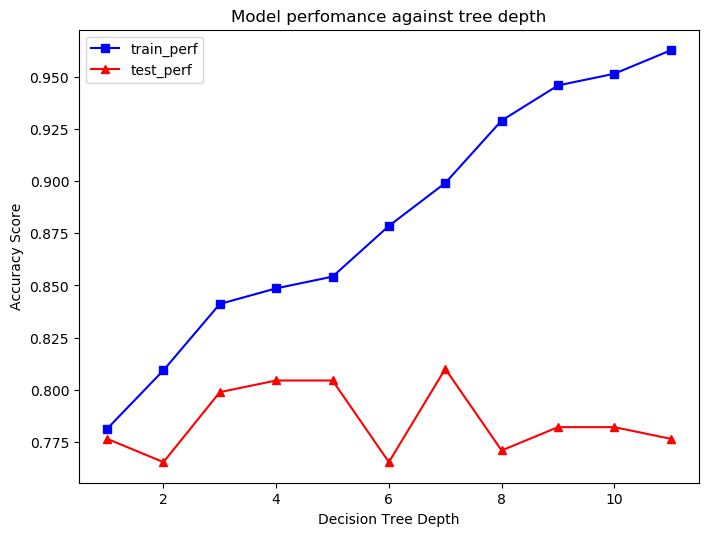

In [27]:
#visualise model performance against tree depth (train vs. test)
plt.plot(df2['depth'], df2['train_perf'], 'bs-')
plt.plot(df2['depth'], df2['test_perf'], 'r^-')
plt.xlabel('Decision Tree Depth')
plt.ylabel('Accuracy Score')
plt.title('Model perfomance against tree depth')
plt.legend()
plt.savefig('decison_tree_fit.png') #useful to save plots as image. Always before plt.show()
plt.show()

The deeper the tree, the more accurate the prediction in the training data sample. This makes sense since the model fits the data more and more precisely. However, in the test dataset, the depth of the tree does not seem to correlate with a significant increase in accuracy. So, in this Titanic dataset, it appears that deeper (more complicated) trees are unnecessary to achieve better prediction.

## Fitting a random forest

Next, I fit a random forest using a random forest classifier. I use the same sequential steps as for fitting my trees.

In [28]:
#step 2: create an empty random forest classifier, specify parameters (number of trees/leaves)
#I chose 100 trees and the minimum number of data points in the leaf nodes = 5
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5)
rf #check random forest created + parameters are correct

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
#step 3: fit random forest model with training data
rf.fit(X_train, Y_train)
#step 4: predict Y outcome in test data using X test, store predictions in Y_pred
Y_pred = rf.predict(X_test)

## Random forest: model performance

In [30]:
#step 5: evaluate model perfomance
#confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[92 11]
 [23 53]]


In [31]:
#accuracy score
accuracy_score(Y_test, Y_pred)

0.8100558659217877

In [32]:
#manually check accuracy = (TP+TN)/total n
(90+53)/(90+13+23+53) #correct

0.7988826815642458

In [33]:
#classification report
print(metrics.classification_report(Y_test, Y_pred))
#n = 179 (bottom right corner)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       103
           1       0.83      0.70      0.76        76

   micro avg       0.81      0.81      0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



## Interpretation

The predictions of this random forest are approx. 80% accurate.

Precision: Of all the passengers labelled by the model as dead, 79% actually died. Of all the passengers labelled by the model as survivors, 83% actually survived.

Recall: Of all the passengers that truly died, the model correctly labelled 89% of them. Of all the passengers that truly survived, the model correctly labelled 68% of them. This random forest is very good predicting deads, but less so at predicting survivors.

In [36]:
#ROC curve - first, need to compute probabilities in the test sample
prob = rf.predict_proba(X_test)
#select second column (Y) only
Y_prob = prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test,Y_prob)

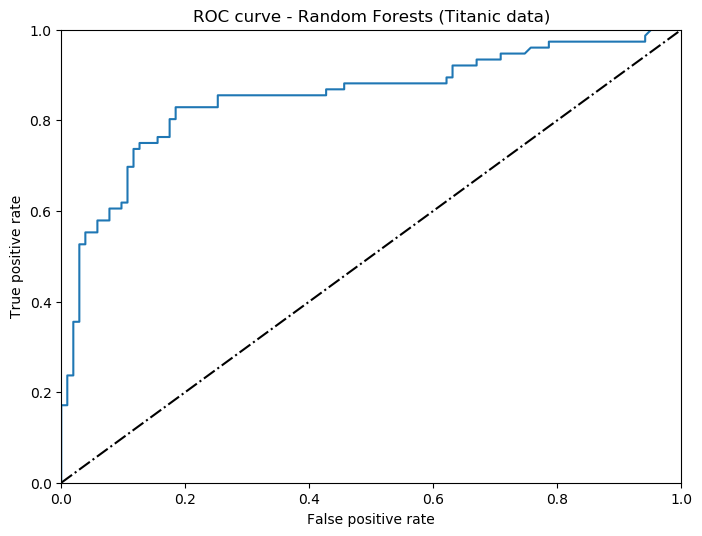

In [37]:
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot([0, 1], [0, 1],'k-.') #nice dotted line
#set axes start to zero
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve - Random Forests (Titanic data)')
plt.show()

In [38]:
#area under ROC curve
metrics.roc_auc_score(Y_test, Y_prob)

0.8514307613694428

The area under the curve is 85%, which means there is an 85% chance that this random forest is able to distinguish between the two classes (survivors and deads).